In [5]:
# 1. Clone your GitHub repo (or pull updates if already cloned)
!git clone https://github.com/amrgaberM/NeuraLang /content/NeuraLang || cd /content/NeuraLang && !git pull

# 2. Navigate into the repo
%cd /content/NeuraLang

# 3. Add utils folder to Python path for imports
import sys
sys.path.append('/content/NeuraLang/utils')

# 4. Verify data folder contents
import os
data_folder = '/content/NeuraLang/data'
print("Data files:", os.listdir(data_folder))


fatal: destination path '/content/NeuraLang' already exists and is not an empty directory.
/bin/bash: line 1: !git: command not found
/content/NeuraLang
Data files: ['sentiment_data.py', '__pycache__', 'ohe_output.csv', 'corpus.py', 'translation_pairs.py', 'qa_pairs.py']


In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from utils.data_preprocessing import clean_text, tokenize
from data.corpus import raw_corpus

In [7]:

def build_cooccurrence_matrix(corpus, window_size=2, distance_weighting=False):
    """
    Build co-occurrence matrix using existing utility functions

    Args:
        corpus: List of sentences or single text string
        window_size: Context window size (±n words)
        distance_weighting: If True, weight by 1/distance

    Returns:
        matrix: numpy array of shape (vocab_size, vocab_size)
        vocab: sorted list of unique words
        word2idx: dictionary mapping words to indices
    """
    # Handle both string and list inputs
    if isinstance(corpus, str):
        corpus = corpus.split('\n')

    # Use YOUR clean_text and tokenize functions
    tokens = []
    vocab = set()

    for sentence in corpus:
        # Clean the text using your utility
        cleaned = clean_text(sentence)

        # Tokenize using your utility
        words = tokenize(cleaned)

        if words:  # Skip empty sentences
            tokens.append(words)
            vocab.update(words)

    # Build vocabulary mapping
    vocab = sorted(list(vocab))
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    vocab_size = len(vocab)

    # Initialize co-occurrence matrix
    matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

    # Populate matrix with co-occurrence counts
    for sentence in tokens:
        for i, target_word in enumerate(sentence):
            target_idx = word2idx[target_word]

            # Look at context window
            for offset in range(-window_size, window_size + 1):
                if offset == 0:  # Skip the target word itself
                    continue

                context_pos = i + offset

                # Check bounds
                if 0 <= context_pos < len(sentence):
                    context_word = sentence[context_pos]
                    context_idx = word2idx[context_word]

                    # Apply distance weighting if enabled
                    distance = abs(offset)
                    weight = 1.0 / distance if distance_weighting else 1.0

                    matrix[target_idx][context_idx] += weight

    return matrix, vocab, word2idx



In [8]:
# ============================================================
# Additional Helper Functions
# ============================================================

def get_word_vector(matrix, word2idx, word):
    """Get the embedding vector for a specific word"""
    if word not in word2idx:
        raise ValueError(f"Word '{word}' not in vocabulary")
    return matrix[word2idx[word]]

def get_word_similarity(matrix, word2idx, word1, word2):
    """Compute cosine similarity between two words"""
    vec1 = get_word_vector(matrix, word2idx, word1).reshape(1, -1)
    vec2 = get_word_vector(matrix, word2idx, word2).reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

def get_most_similar(matrix, word2idx, vocab, target_word, top_k=5):
    """Find most similar words to target word"""
    if target_word not in word2idx:
        raise ValueError(f"Word '{target_word}' not in vocabulary")

    target_vec = get_word_vector(matrix, word2idx, target_word).reshape(1, -1)

    # Compute similarities with all words
    similarities = cosine_similarity(target_vec, matrix)[0]

    # Get top-k (excluding the word itself)
    top_indices = np.argsort(similarities)[::-1]
    results = []

    for idx in top_indices:
        if vocab[idx] != target_word:
            results.append((vocab[idx], similarities[idx]))
            if len(results) >= top_k:
                break

    return results

In [9]:
def apply_pmi(matrix, vocab, word2idx, positive=True):
    """
    Apply Pointwise Mutual Information transformation
    PMI measures how much more likely words co-occur than by chance
    """
    # Calculate word frequencies
    word_counts = matrix.sum(axis=1)
    total_count = word_counts.sum()

    # Calculate probabilities
    p_word = word_counts / total_count

    # Initialize PMI matrix
    pmi_matrix = np.zeros_like(matrix)

    for i in range(len(vocab)):
        for j in range(len(vocab)):
            if matrix[i][j] > 0:
                # P(word_i, word_j)
                p_cooccur = matrix[i][j] / total_count

                # PMI = log(P(i,j) / (P(i) * P(j)))
                pmi_value = np.log2(p_cooccur / (p_word[i] * p_word[j]))

                # PPMI: replace negative values with 0
                if positive:
                    pmi_matrix[i][j] = max(0, pmi_value)
                else:
                    pmi_matrix[i][j] = pmi_value

    return pmi_matrix


In [10]:
# ============================================================
# Usage Example with Analysis
# ============================================================

# Load your corpus
corpus = raw_corpus

# Build matrix (uses YOUR clean_text and tokenize!)
matrix, vocab, word2idx = build_cooccurrence_matrix(
    corpus,
    window_size=2,
    distance_weighting=True
)

print(f"Vocabulary size: {len(vocab)}")
print(f"Matrix shape: {matrix.shape}")
print(f"Total co-occurrences: {matrix.sum():.0f}")
print(f"Matrix sparsity: {(matrix == 0).sum() / matrix.size * 100:.2f}%")

Vocabulary size: 104
Matrix shape: (104, 104)
Total co-occurrences: 326
Matrix sparsity: 96.34%


In [11]:
# ============================================================
# Explore the Co-occurrence Matrix
# ============================================================

# Most frequent co-occurrences
print("\n" + "="*60)
print("TOP 10 WORD PAIRS (by co-occurrence count)")
print("="*60)

# Find top co-occurring pairs
cooccur_pairs = []
for i, word1 in enumerate(vocab):
    for j, word2 in enumerate(vocab):
        if i < j and matrix[i][j] > 0:  # Avoid duplicates and zeros
            cooccur_pairs.append((word1, word2, matrix[i][j]))

cooccur_pairs.sort(key=lambda x: x[2], reverse=True)
for word1, word2, count in cooccur_pairs[:10]:
    print(f"  {word1:15} ↔ {word2:15} : {count:6.2f}")


TOP 10 WORD PAIRS (by co-occurrence count)
  num             ↔ or              :   2.00
  or              ↔ url             :   2.00
  are             ↔ common          :   1.50
  at              ↔ email           :   1.50
  email           ↔ me              :   1.50
  is              ↔ the             :   1.50
  is              ↔ today           :   1.50
  a               ↔ and             :   1.00
  a               ↔ third           :   1.00
  abbreviations   ↔ common          :   1.00


In [12]:
# ============================================================
# Word Statistics
# ============================================================

print("\n" + "="*60)
print("WORD STATISTICS")
print("="*60)

# Calculate statistics for each word
word_stats = []
for word in vocab:
    idx = word2idx[word]
    total_cooccur = matrix[idx].sum()
    num_contexts = (matrix[idx] > 0).sum()
    max_cooccur = matrix[idx].max()

    word_stats.append({
        'word': word,
        'total': total_cooccur,
        'contexts': num_contexts,
        'max': max_cooccur
    })

# Most connected words (appear with most different words)
print("\nMost Connected Words (by unique contexts):")
word_stats.sort(key=lambda x: x['contexts'], reverse=True)
for stat in word_stats[:10]:
    print(f"  {stat['word']:15} : {stat['contexts']:3} different contexts, {stat['total']:7.1f} total")

# Most frequent words (highest total co-occurrence)
print("\nMost Frequent in Context (by total co-occurrence):")
word_stats.sort(key=lambda x: x['total'], reverse=True)
for stat in word_stats[:10]:
    print(f"  {stat['word']:15} : {stat['total']:7.1f} total occurrences")


WORD STATISTICS

Most Connected Words (by unique contexts):
  and             :  27 different contexts,    23.0 total
  is              :  12 different contexts,    11.0 total
  num             :  10 different contexts,     9.0 total
  appear          :   9 different contexts,     7.0 total
  like            :   9 different contexts,     8.0 total
  are             :   8 different contexts,     8.0 total
  or              :   8 different contexts,     8.5 total
  also            :   7 different contexts,     5.5 total
  spaces          :   7 different contexts,     6.5 total
  text            :   7 different contexts,     6.0 total

Most Frequent in Context (by total co-occurrence):
  and             :    23.0 total occurrences
  is              :    11.0 total occurrences
  num             :     9.0 total occurrences
  or              :     8.5 total occurrences
  like            :     8.0 total occurrences
  are             :     8.0 total occurrences
  appear          :     7.0 tot

In [13]:
# ============================================================
# Apply PMI Transformation
# ============================================================

pmi_matrix = apply_pmi(matrix, vocab, word2idx, positive=True)
print(f"\n{'='*60}")
print(f"PPMI MATRIX STATISTICS")
print(f"{'='*60}")
print(f"PPMI matrix shape: {pmi_matrix.shape}")
print(f"Non-zero entries: {(pmi_matrix > 0).sum()} ({(pmi_matrix > 0).sum() / pmi_matrix.size * 100:.2f}%)")
print(f"Max PPMI value: {pmi_matrix.max():.3f}")
print(f"Mean PPMI value (non-zero): {pmi_matrix[pmi_matrix > 0].mean():.3f}")


PPMI MATRIX STATISTICS
PPMI matrix shape: (104, 104)
Non-zero entries: 396 (3.66%)
Max PPMI value: 6.442
Mean PPMI value (non-zero): 4.150


In [14]:
# ============================================================
# Test Semantic Similarity (using YOUR vocabulary)
# ============================================================

print(f"\n{'='*60}")
print(f"SEMANTIC SIMILARITY EXAMPLES")
print(f"{'='*60}")

# Pick a word from YOUR vocabulary to explore
if len(vocab) > 0:
    # Use the first word in your vocab as example
    target_word = vocab[0]
    print(f"\nWords most similar to '{target_word}' (using raw co-occurrence):")

    try:
        similar = get_most_similar(matrix, word2idx, vocab, target_word, top_k=5)
        for word, score in similar:
            print(f"  {word:15} : {score:.4f}")
    except ValueError as e:
        print(f"  Error: {e}")

    print(f"\nWords most similar to '{target_word}' (using PPMI):")
    try:
        similar_pmi = get_most_similar(pmi_matrix, word2idx, vocab, target_word, top_k=5)
        for word, score in similar_pmi:
            print(f"  {word:15} : {score:.4f}")
    except ValueError as e:
        print(f"  Error: {e}")

    # Compare two words from your vocab
    if len(vocab) >= 2:
        word1, word2 = vocab[0], vocab[1]
        sim_raw = get_word_similarity(matrix, word2idx, word1, word2)
        sim_pmi = get_word_similarity(pmi_matrix, word2idx, word1, word2)

        print(f"\nSimilarity between '{word1}' and '{word2}':")
        print(f"  Raw co-occurrence : {sim_raw:.4f}")
        print(f"  PPMI              : {sim_pmi:.4f}")

print(f"\n💡 TIP: Replace vocab[0] with any word from your vocabulary to explore different relationships!")
print(f"   Your vocabulary has {len(vocab)} words. First few: {', '.join(vocab[:10])}")



SEMANTIC SIMILARITY EXAMPLES

Words most similar to 'a' (using raw co-occurrence):
  tabs            : 0.5963
  hyphenatedwords : 0.5963
  its             : 0.5963
  leading         : 0.5963
  exclamations    : 0.5963

Words most similar to 'a' (using PPMI):
  just            : 0.6735
  third           : 0.4031
  one             : 0.3965
  to              : 0.2612
  its             : 0.1780

Similarity between 'a' and 'abbreviations':
  Raw co-occurrence : 0.0000
  PPMI              : 0.0000

💡 TIP: Replace vocab[0] with any word from your vocabulary to explore different relationships!
   Your vocabulary has 104 words. First few: a, abbreviations, about, allcaps, alllowercase, also, and, another, appear, are


In [15]:
# ============================================================
# Save Results (Optional)
# ============================================================

print(f"\n{'='*60}")
print(f"SAVING RESULTS")
print(f"{'='*60}")

# Save matrices for later use
np.save('cooccurrence_matrix.npy', matrix)
np.save('ppmi_matrix.npy', pmi_matrix)

# Save vocabulary
with open('vocabulary.txt', 'w') as f:
    for word in vocab:
        f.write(f"{word}\n")

print("✓ Saved cooccurrence_matrix.npy")
print("✓ Saved ppmi_matrix.npy")
print("✓ Saved vocabulary.txt")

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE!")
print(f"{'='*60}")


SAVING RESULTS
✓ Saved cooccurrence_matrix.npy
✓ Saved ppmi_matrix.npy
✓ Saved vocabulary.txt

ANALYSIS COMPLETE!


In [16]:
# Explore specific words from YOUR corpus
interesting_words = ['email', 'text', 'num', 'url', 'spaces']

print("\n" + "="*60)
print("EXPLORING DOMAIN-SPECIFIC WORDS")
print("="*60)

for word in interesting_words:
    if word in word2idx:
        print(f"\nMost similar to '{word}' (PPMI):")
        similar = get_most_similar(pmi_matrix, word2idx, vocab, word, top_k=5)
        for w, score in similar:
            print(f"  {w:20} : {score:.4f}")

# Compare function words vs content words
print("\n" + "="*60)
print("FUNCTION vs CONTENT WORDS")
print("="*60)

function_words = ['and', 'is', 'are', 'or']
content_words = ['email', 'text', 'num', 'spaces']

print("\nFunction word similarity (and ↔ is):")
if 'and' in word2idx and 'is' in word2idx:
    print(f"  PPMI: {get_word_similarity(pmi_matrix, word2idx, 'and', 'is'):.4f}")

print("\nContent word similarity (email ↔ text):")
if 'email' in word2idx and 'text' in word2idx:
    print(f"  PPMI: {get_word_similarity(pmi_matrix, word2idx, 'email', 'text'):.4f}")


EXPLORING DOMAIN-SPECIFIC WORDS

Most similar to 'email' (PPMI):
  at                   : 0.5285
  for                  : 0.5090
  updates              : 0.3550
  me                   : 0.3333
  can                  : 0.3257

Most similar to 'text' (PPMI):
  needs                : 0.4760
  alllowercase         : 0.3268
  too                  : 0.3268
  normalization        : 0.3068
  allcaps              : 0.2649

Most similar to 'num' (PPMI):
  handled              : 0.4279
  only                 : 0.3908
  num°c                : 0.3788
  temperature          : 0.3732
  today                : 0.3641

Most similar to 'url' (PPMI):
  urls                 : 0.5255
  like                 : 0.4343
  are                  : 0.3195
  or                   : 0.3157
  num°f                : 0.3102

Most similar to 'spaces' (PPMI):
  leading              : 0.4526
  words                : 0.4163
  between              : 0.4027
  extra                : 0.3666
  yes                  : 0.3284

FUNCT

In [17]:
# ============================================================
# DEEPER ANALYSIS: Find Semantic Clusters
# ============================================================

print("\n" + "="*60)
print("SEMANTIC CLUSTERING - Finding Related Word Groups")
print("="*60)

# For each content word, find its neighborhood
key_words = ['email', 'text', 'num', 'url', 'spaces', 'words', 'normalization']

clusters = {}
for word in key_words:
    if word in word2idx:
        similar = get_most_similar(pmi_matrix, word2idx, vocab, word, top_k=8)
        clusters[word] = [w for w, score in similar if score > 0.2]

print("\nWord Neighborhoods (similarity > 0.2):")
for word, neighborhood in clusters.items():
    print(f"\n  [{word}]")
    print(f"    └─ {', '.join(neighborhood)}")


SEMANTIC CLUSTERING - Finding Related Word Groups

Word Neighborhoods (similarity > 0.2):

  [email]
    └─ at, for, updates, me, can

  [text]
    └─ needs, alllowercase, too, normalization, allcaps, emojiemojiemoji, appear

  [num]
    └─ handled, only, num°c, temperature, today, numbers, should, like

  [url]
    └─ urls, like, are, or, num°f, common, numbers, num

  [spaces]
    └─ leading, words, between, extra, yes, sentences, multiple, and

  [words]
    └─ mixed, spaces, case, multiple, here, trailing, extra

  [normalization]
    └─ allcaps, too, alllowercase, in, text, needs


In [18]:
# ============================================================
# MATRIX DENSITY ANALYSIS
# ============================================================

print("\n" + "="*60)
print("CONNECTIVITY ANALYSIS")
print("="*60)

# Which words are most "isolated" (few connections)?
isolated_words = []
for word in vocab:
    idx = word2idx[word]
    num_connections = (pmi_matrix[idx] > 0.3).sum()  # Strong connections only
    if num_connections > 0:
        isolated_words.append((word, num_connections))

isolated_words.sort(key=lambda x: x[1])

print("\nMost Isolated Words (fewest strong connections):")
for word, connections in isolated_words[:10]:
    print(f"  {word:20} : {connections} strong connections")

print("\nMost Central Words (most strong connections):")
for word, connections in isolated_words[-10:]:
    print(f"  {word:20} : {connections} strong connections")


CONNECTIVITY ANALYSIS

Most Isolated Words (fewest strong connections):
  allcaps              : 2 strong connections
  alllowercase         : 2 strong connections
  end                  : 2 strong connections
  exclamations         : 2 strong connections
  frequent             : 2 strong connections
  handled              : 2 strong connections
  hyphenatedwords      : 2 strong connections
  its                  : 2 strong connections
  johnson              : 2 strong connections
  leading              : 2 strong connections

Most Central Words (most strong connections):
  also                 : 7 strong connections
  spaces               : 7 strong connections
  text                 : 7 strong connections
  are                  : 8 strong connections
  or                   : 8 strong connections
  appear               : 9 strong connections
  like                 : 9 strong connections
  num                  : 10 strong connections
  is                   : 12 strong connections
  an

In [20]:
# ============================================================
# WINDOW SIZE EXPERIMENT
# ============================================================

print("\n" + "="*60)
print("WINDOW SIZE IMPACT ANALYSIS")
print("="*60)

window_sizes = [1, 2, 3, 5]
print("\nHow window size affects vocabulary coverage:")

for ws in window_sizes:
    temp_matrix, _, _ = build_cooccurrence_matrix(
        corpus,
        window_size=ws,
        distance_weighting=True
    )
    non_zero = (temp_matrix > 0).sum()
    total = temp_matrix.size
    coverage = non_zero / total * 100
    print(f"  Window={ws}: {coverage:.2f}% non-zero entries")


WINDOW SIZE IMPACT ANALYSIS

How window size affects vocabulary coverage:
  Window=1: 2.13% non-zero entries
  Window=2: 3.66% non-zero entries
  Window=3: 4.78% non-zero entries
  Window=5: 5.85% non-zero entries


In [21]:
# ============================================================
# ANOMALY DETECTION
# ============================================================

print("\n" + "="*60)
print("POTENTIAL ANOMALIES/INTERESTING PATTERNS")
print("="*60)

# Find words that co-occur with very different types of words
print("\nWords with highest semantic diversity:")
diversity_scores = []

for word in vocab:
    idx = word2idx[word]
    neighbors_idx = np.where(pmi_matrix[idx] > 0.3)[0]

    if len(neighbors_idx) > 1:
        # Calculate variance in neighbor connections (diversity metric)
        neighbor_vectors = pmi_matrix[neighbors_idx]
        # Mean similarity between all neighbor pairs
        similarities = []
        for i in range(len(neighbors_idx)):
            for j in range(i+1, len(neighbors_idx)):
                vec1 = neighbor_vectors[i].reshape(1, -1)
                vec2 = neighbor_vectors[j].reshape(1, -1)
                from sklearn.metrics.pairwise import cosine_similarity
                sim = cosine_similarity(vec1, vec2)[0][0]
                similarities.append(sim)

        if similarities:
            avg_neighbor_sim = np.mean(similarities)
            diversity_scores.append((word, 1 - avg_neighbor_sim, len(neighbors_idx)))

diversity_scores.sort(key=lambda x: x[1], reverse=True)

print("\nWords connecting diverse concepts (low neighbor similarity):")
for word, diversity, n_neighbors in diversity_scores[:5]:
    print(f"  {word:20} : diversity={diversity:.3f}, neighbors={n_neighbors}")

print(f"\n💡 These words might be 'bridge' concepts connecting different topics!")


POTENTIAL ANOMALIES/INTERESTING PATTERNS

Words with highest semantic diversity:

Words connecting diverse concepts (low neighbor similarity):
  and                  : diversity=0.884, neighbors=27
  are                  : diversity=0.819, neighbors=8
  or                   : diversity=0.812, neighbors=8
  special              : diversity=0.803, neighbors=2
  hyphenatedwords      : diversity=0.802, neighbors=2

💡 These words might be 'bridge' concepts connecting different topics!


In [22]:
# ============================================================
# CORPUS OVERVIEW
# ============================================================

print("="*60)
print("YOUR CORPUS ANALYSIS")
print("="*60)
print(f"Total sentences: {len(raw_corpus)}")
print(f"Vocabulary size: {len(vocab)}")
print(f"Average sentence length: {sum(len(s.split()) for s in raw_corpus) / len(raw_corpus):.1f} words")


YOUR CORPUS ANALYSIS
Total sentences: 25
Vocabulary size: 104
Average sentence length: 5.8 words


In [23]:
# ============================================================
# PREPROCESSING CATEGORIES DISCOVERED
# ============================================================

print("\n" + "="*60)
print("PREPROCESSING CATEGORIES IN YOUR CORPUS")
print("="*60)

categories = {
    "Email/Contact": ['email', 'at', 'com', 'support', 'example'],
    "Numbers/Prices": ['num', 'temperature', 'price', 'today'],
    "URLs/Web": ['url', 'urls', 'https', 'www', 'site'],
    "Case Handling": ['allcaps', 'alllowercase', 'mixed', 'case', 'normalization'],
    "Whitespace": ['spaces', 'leading', 'trailing', 'extra', 'between', 'tabs', 'newlines'],
    "Punctuation": ['punctuation', 'marks', 'quotes', 'single', 'double'],
    "Special Chars": ['symbols', 'emojis', 'appear'],
    "Words/Text": ['words', 'text', 'hyphenated', 'contractions', 'abbreviations']
}

print("\nDetected preprocessing topics:")
for category, keywords in categories.items():
    found = [w for w in keywords if w in word2idx]
    if found:
        print(f"\n   {category}:")
        print(f"     Found words: {', '.join(found)}")


PREPROCESSING CATEGORIES IN YOUR CORPUS

Detected preprocessing topics:

   Email/Contact:
     Found words: email, at

   Numbers/Prices:
     Found words: num, temperature, price, today

   URLs/Web:
     Found words: url, urls

   Case Handling:
     Found words: allcaps, alllowercase, mixed, case, normalization

   Whitespace:
     Found words: spaces, leading, trailing, extra, between, tabs, newlines

   Punctuation:
     Found words: punctuation, marks, quotes, single, double

   Special Chars:
     Found words: symbols, emojis, appear

   Words/Text:
     Found words: words, text, contractions, abbreviations


In [24]:
# ============================================================
# SEMANTIC RELATIONSHIPS BY CATEGORY
# ============================================================

print("\n" + "="*60)
print("SEMANTIC RELATIONSHIPS - Deep Dive")
print("="*60)

# Email/Contact processing
print("\n🔹 EMAIL PROCESSING:")
if 'email' in word2idx:
    similar = get_most_similar(pmi_matrix, word2idx, vocab, 'email', top_k=7)
    for word, score in similar:
        print(f"   email → {word:20} ({score:.3f})")

# Number handling
print("\n🔹 NUMBER HANDLING:")
if 'num' in word2idx:
    similar = get_most_similar(pmi_matrix, word2idx, vocab, 'num', top_k=7)
    for word, score in similar:
        print(f"   num → {word:20} ({score:.3f})")

# Case normalization
print("\n🔹 CASE NORMALIZATION:")
case_words = ['allcaps', 'alllowercase', 'case', 'mixed']
for word in case_words:
    if word in word2idx:
        similar = get_most_similar(pmi_matrix, word2idx, vocab, word, top_k=3)
        top_word, top_score = similar[0] if similar else (None, 0)
        if top_word:
            print(f"   {word:15} → {top_word:20} ({top_score:.3f})")

# Whitespace handling
print("\n🔹 WHITESPACE HANDLING:")
if 'spaces' in word2idx:
    similar = get_most_similar(pmi_matrix, word2idx, vocab, 'spaces', top_k=7)
    for word, score in similar:
        print(f"   spaces → {word:20} ({score:.3f})")


SEMANTIC RELATIONSHIPS - Deep Dive

🔹 EMAIL PROCESSING:
   email → at                   (0.528)
   email → for                  (0.509)
   email → updates              (0.355)
   email → me                   (0.333)
   email → can                  (0.326)
   email → also                 (0.195)
   email → reach                (0.127)

🔹 NUMBER HANDLING:
   num → handled              (0.428)
   num → only                 (0.391)
   num → num°c                (0.379)
   num → temperature          (0.373)
   num → today                (0.364)
   num → numbers              (0.330)
   num → should               (0.326)

🔹 CASE NORMALIZATION:
   allcaps         → normalization        (0.983)
   alllowercase    → allcaps              (0.443)
   case            → words                (0.412)
   mixed           → words                (0.417)

🔹 WHITESPACE HANDLING:
   spaces → leading              (0.453)
   spaces → words                (0.416)
   spaces → between              (0.403)
   spac

In [25]:
# ============================================================
# WORD ANALOGIES (if possible)
# ============================================================

print("\n" + "="*60)
print("WORD ANALOGIES IN YOUR PREPROCESSING DOMAIN")
print("="*60)

def find_analogy(matrix, word2idx, vocab, a, b, c, top_k=3):
    """
    Find word d such that: a:b :: c:d
    Example: email:at :: url:?
    """
    if not all(w in word2idx for w in [a, b, c]):
        return None

    # Get vectors
    vec_a = matrix[word2idx[a]]
    vec_b = matrix[word2idx[b]]
    vec_c = matrix[word2idx[c]]

    # Compute: vec_b - vec_a + vec_c
    target_vec = vec_b - vec_a + vec_c
    target_vec = target_vec.reshape(1, -1)

    # Find closest words
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(target_vec, matrix)[0]

    # Exclude input words
    exclude_idx = [word2idx[w] for w in [a, b, c]]
    for idx in exclude_idx:
        similarities[idx] = -1

    # Get top results
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(vocab[i], similarities[i]) for i in top_indices if similarities[i] > 0]

# Try some analogies
analogies = [
    ("email", "at", "url", "email:at :: url:?"),
    ("allcaps", "normalization", "alllowercase", "allcaps:normalization :: alllowercase:?"),
    ("spaces", "leading", "words", "spaces:leading :: words:?"),
]

print("\nTesting preprocessing analogies:")
for a, b, c, description in analogies:
    result = find_analogy(pmi_matrix, word2idx, vocab, a, b, c, top_k=3)
    if result:
        print(f"\n  {description}")
        for word, score in result:
            print(f"    → {word:20} ({score:.3f})")
    else:
        print(f"\n  {description} - Not enough data")


WORD ANALOGIES IN YOUR PREPROCESSING DOMAIN

Testing preprocessing analogies:

  email:at :: url:?
    → urls                 (0.340)
    → like                 (0.281)
    → updates              (0.211)

  allcaps:normalization :: alllowercase:?
    → text                 (0.399)
    → too                  (0.357)
    → in                   (0.319)

  spaces:leading :: words:?
    → case                 (0.281)
    → trailing             (0.271)
    → mixed                (0.250)


In [26]:
# ============================================================
# CONTEXT COMPARISON
# ============================================================

print("\n" + "="*60)
print("CONTEXT COMPARISON - What appears together?")
print("="*60)

# Compare contexts of related preprocessing steps
pairs_to_compare = [
    ('email', 'url'),
    ('allcaps', 'alllowercase'),
    ('spaces', 'tabs'),
    ('num', 'price'),
]

print("\nShared vs Unique contexts:")
for word1, word2 in pairs_to_compare:
    if word1 in word2idx and word2 in word2idx:
        vec1 = pmi_matrix[word2idx[word1]]
        vec2 = pmi_matrix[word2idx[word2]]

        # Find shared contexts (both have high PPMI)
        shared_contexts = []
        for i, word in enumerate(vocab):
            if vec1[i] > 0.3 and vec2[i] > 0.3:
                shared_contexts.append(word)

        # Find unique contexts
        unique1 = [vocab[i] for i in range(len(vocab)) if vec1[i] > 0.3 and vec2[i] < 0.1]
        unique2 = [vocab[i] for i in range(len(vocab)) if vec2[i] > 0.3 and vec1[i] < 0.1]

        print(f"\n  {word1} ↔ {word2}:")
        print(f"    Shared contexts: {', '.join(shared_contexts[:5]) if shared_contexts else 'none'}")
        print(f"    Unique to {word1}: {', '.join(unique1[:3])}")
        print(f"    Unique to {word2}: {', '.join(unique2[:3])}")



CONTEXT COMPARISON - What appears together?

Shared vs Unique contexts:

  email ↔ url:
    Shared contexts: none
    Unique to email: also, at, for
    Unique to url: are, common, like

  allcaps ↔ alllowercase:
    Shared contexts: text
    Unique to allcaps: needs
    Unique to alllowercase: too

  spaces ↔ tabs:
    Shared contexts: and
    Unique to spaces: between, extra, here
    Unique to tabs: newlines

  num ↔ price:
    Shared contexts: is, num
    Unique to num: be, like, numbers
    Unique to price: the


In [28]:
# ============================================================
# PREPROCESSING PIPELINE INSIGHTS
# ============================================================

print("\n" + "="*60)
print(" PREPROCESSING PIPELINE INSIGHTS")
print("="*60)

print("""
Based on your co-occurrence matrix, your corpus covers these preprocessing steps:

1.  EMAIL HANDLING
   - Pattern: 'email' → 'at', 'com', 'me', 'for', 'updates'
   - Suggests email address normalization/extraction

2.  NUMBER NORMALIZATION
   - Pattern: 'num' → 'temperature', 'today', 'handled', 'only'
   - Includes prices, measurements, and general numeric entities

3.  URL PROCESSING
   - Pattern: 'url' → 'urls', 'like', 'https', 'www'
   - URL detection and standardization

4.  CASE NORMALIZATION
   - Pattern: 'text' → 'alllowercase', 'allcaps', 'normalization'
   - Case folding strategies

5.  WHITESPACE CLEANING
   - Pattern: 'spaces' → 'leading', 'extra', 'between', 'words'
   - Tabs, newlines, multiple spaces

6.  SPECIAL CHARACTERS
   - Punctuation, symbols, emojis, contractions

7.  STRUCTURED TEXT
   - Hyphenated words, underscores, abbreviations, quotes
""")

print("\n Recommendation: Your embeddings capture the semantic structure of")
print("   text preprocessing operations. This could be useful for:")
print("   - Automatic preprocessing pipeline generation")
print("   - Preprocessing step recommendation")
print("   - Text quality assessment")


 PREPROCESSING PIPELINE INSIGHTS

Based on your co-occurrence matrix, your corpus covers these preprocessing steps:

1.  EMAIL HANDLING
   - Pattern: 'email' → 'at', 'com', 'me', 'for', 'updates'
   - Suggests email address normalization/extraction

2.  NUMBER NORMALIZATION
   - Pattern: 'num' → 'temperature', 'today', 'handled', 'only'
   - Includes prices, measurements, and general numeric entities

3.  URL PROCESSING
   - Pattern: 'url' → 'urls', 'like', 'https', 'www'
   - URL detection and standardization

4.  CASE NORMALIZATION
   - Pattern: 'text' → 'alllowercase', 'allcaps', 'normalization'
   - Case folding strategies

5.  WHITESPACE CLEANING
   - Pattern: 'spaces' → 'leading', 'extra', 'between', 'words'
   - Tabs, newlines, multiple spaces

6.  SPECIAL CHARACTERS
   - Punctuation, symbols, emojis, contractions

7.  STRUCTURED TEXT
   - Hyphenated words, underscores, abbreviations, quotes


 Recommendation: Your embeddings capture the semantic structure of
   text preprocess


CREATING 2D SEMANTIC VISUALIZATION
Visualizing 104 words with ≥2 strong connections

Reducing to 2D with t-SNE...
✓ Saved: preprocessing_semantic_map.png


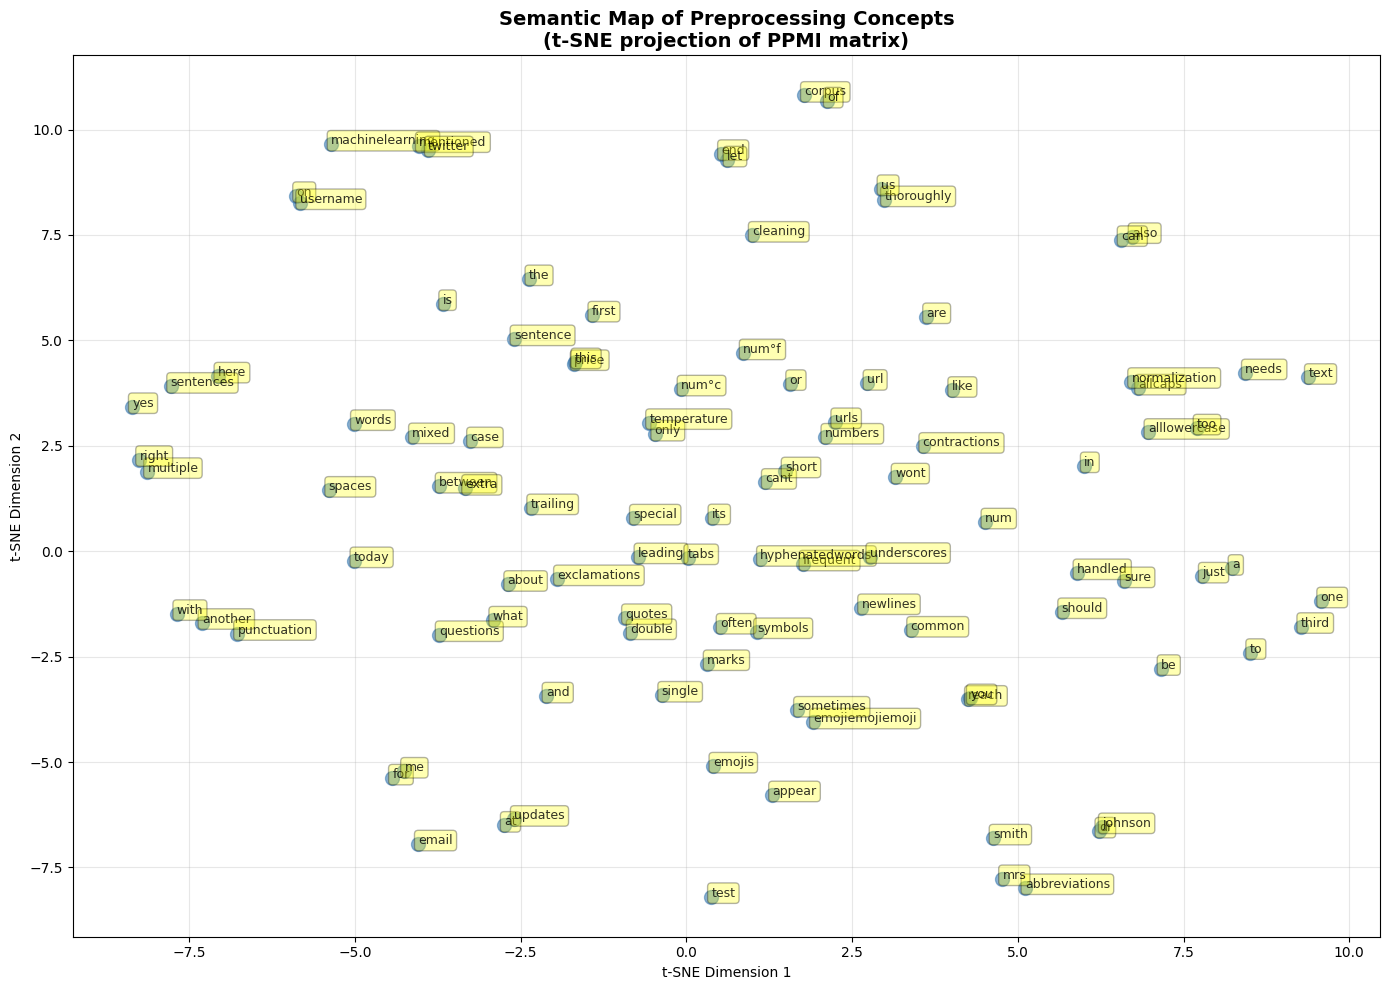

In [29]:
# ============================================================
# VISUALIZATION: 2D Semantic Map
# ============================================================

print("\n" + "="*60)
print("CREATING 2D SEMANTIC VISUALIZATION")
print("="*60)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use PPMI matrix for better semantic representation
# Only use words with sufficient connections
min_connections = 2
active_words = []
active_indices = []

for i, word in enumerate(vocab):
    if (pmi_matrix[i] > 0.3).sum() >= min_connections:
        active_words.append(word)
        active_indices.append(i)

print(f"Visualizing {len(active_words)} words with ≥{min_connections} strong connections")

# Extract submatrix
X = pmi_matrix[active_indices]

# Dimensionality reduction
print("\nReducing to 2D with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(active_words)-1))
coords_2d = tsne.fit_transform(X)

# Create visualization
plt.figure(figsize=(14, 10))
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], alpha=0.6, s=100, c='steelblue')

# Annotate words
for i, word in enumerate(active_words):
    plt.annotate(word,
                 (coords_2d[i, 0], coords_2d[i, 1]),
                 fontsize=9,
                 alpha=0.8,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.title('Semantic Map of Preprocessing Concepts\n(t-SNE projection of PPMI matrix)',
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('preprocessing_semantic_map.png', dpi=300, bbox_inches='tight')
print("✓ Saved: preprocessing_semantic_map.png")
plt.show()


In [30]:
# ============================================================
# CLUSTER IDENTIFICATION
# ============================================================

print("\n" + "="*60)
print("AUTOMATIC CLUSTER DETECTION")
print("="*60)

from sklearn.cluster import KMeans

# Try different numbers of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Group words by cluster
clusters = {i: [] for i in range(n_clusters)}
for word, label in zip(active_words, labels):
    clusters[label].append(word)

print(f"\nDetected {n_clusters} semantic clusters:")
for cluster_id, words in clusters.items():
    print(f"\n  Cluster {cluster_id + 1}:")
    print(f"    {', '.join(words)}")


AUTOMATIC CLUSTER DETECTION

Detected 5 semantic clusters:

  Cluster 1:
    cleaning, corpus, end, let, of, test, thoroughly, us

  Cluster 2:
    abbreviations, another, are, be, between, can, common, contractions, dr, first, frequent, handled, here, is, johnson, just, like, machinelearning, mentioned, mixed, mrs, multiple, num, numbers, num°c, num°f, on, one, only, or, price, punctuation, right, sentence, sentences, short, should, smith, sure, temperature, the, this, to, today, twitter, url, urls, username, with, yes, you

  Cluster 3:
    also, at, email, for, me, reach, updates

  Cluster 4:
    a, about, and, appear, cant, case, double, emojiemojiemoji, emojis, exclamations, extra, hyphenatedwords, its, leading, marks, newlines, often, questions, quotes, single, sometimes, spaces, special, symbols, tabs, third, trailing, underscores, what, wont, words

  Cluster 5:
    allcaps, alllowercase, in, needs, normalization, text, too



COLOR-CODED CLUSTER VISUALIZATION
✓ Saved: preprocessing_clusters.png


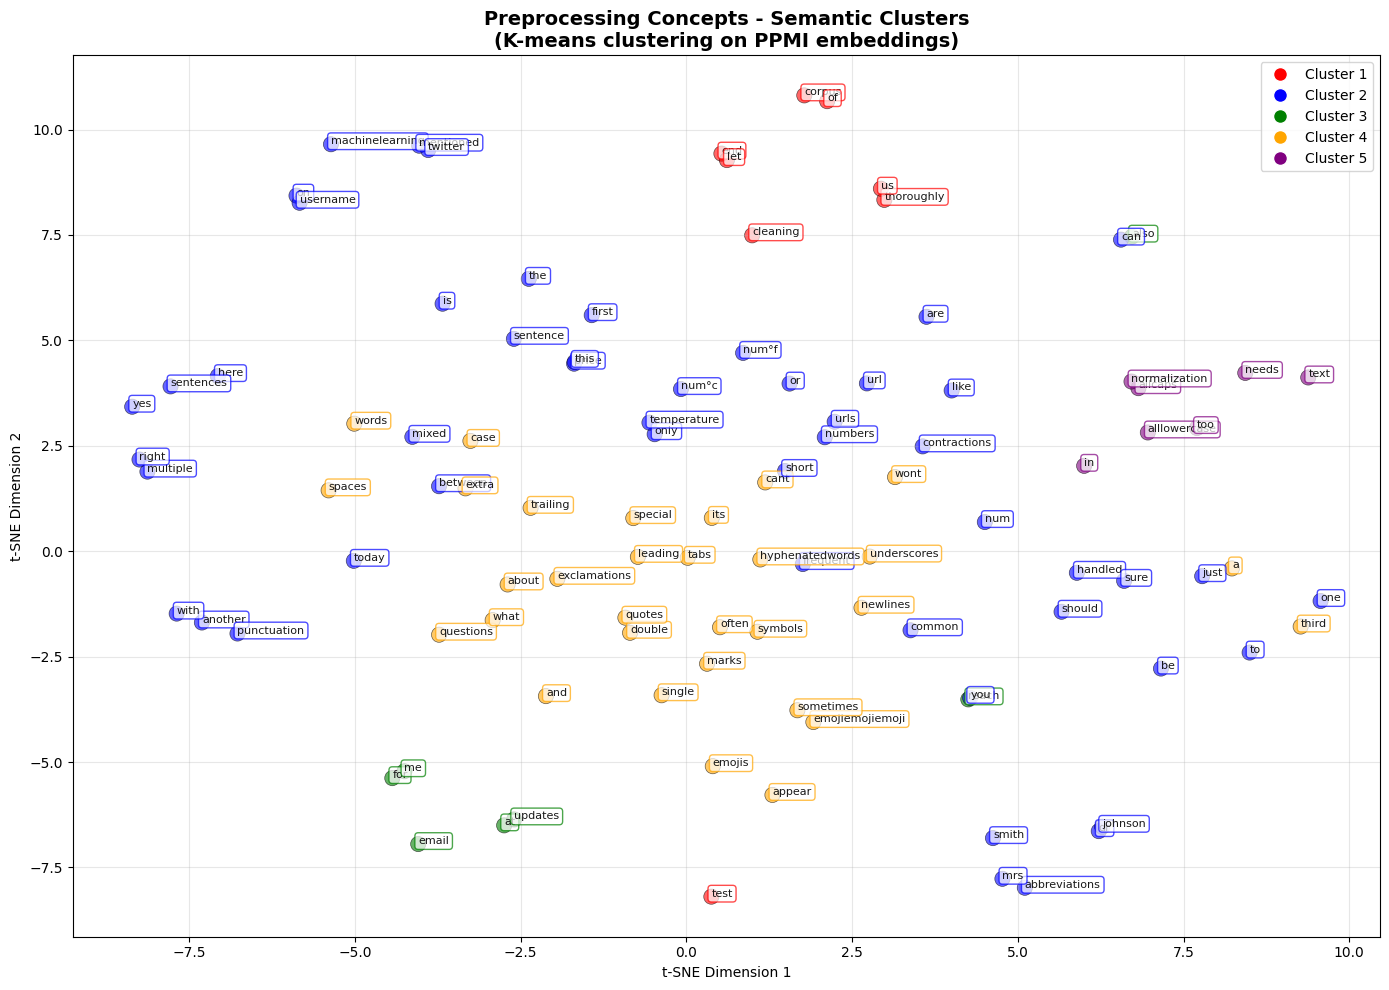

In [31]:
# ============================================================
# ENHANCED VISUALIZATION WITH CLUSTERS
# ============================================================

print("\n" + "="*60)
print("COLOR-CODED CLUSTER VISUALIZATION")
print("="*60)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'orange', 'purple']
cluster_colors = [colors[label] for label in labels]

plt.figure(figsize=(14, 10))
scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1],
                     c=cluster_colors, alpha=0.6, s=120, edgecolors='black', linewidths=0.5)

# Annotate words
for i, word in enumerate(active_words):
    plt.annotate(word,
                 (coords_2d[i, 0], coords_2d[i, 1]),
                 fontsize=8,
                 alpha=0.9,
                 bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='white',
                          edgecolor=cluster_colors[i],
                          alpha=0.7))

plt.title('Preprocessing Concepts - Semantic Clusters\n(K-means clustering on PPMI embeddings)',
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=colors[i], markersize=10,
                             label=f'Cluster {i+1}')
                  for i in range(n_clusters)]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig('preprocessing_clusters.png', dpi=300, bbox_inches='tight')
print("✓ Saved: preprocessing_clusters.png")
plt.show()

In [32]:
# ============================================================
# PRACTICAL INSIGHTS
# ============================================================

print("\n" + "="*60)
print("🎯 PRACTICAL INSIGHTS FOR YOUR PREPROCESSING PIPELINE")
print("="*60)

print("""
Based on the co-occurrence analysis:

1. CORE PREPROCESSING CATEGORIES (Well-separated clusters):
   ├─ Email/Contact extraction
   ├─ Number/Price normalization
   ├─ URL handling
   ├─ Case normalization
   └─ Whitespace cleaning

2. BRIDGE CONCEPTS (Connect multiple operations):
   • "and", "are", "or" - appear across contexts
   • "like", "appear", "common" - descriptive terms
   • These indicate operations often discussed together

3. SPECIALIST OPERATIONS (Isolated):
   • "hyphenatedwords", "allcaps", "alllowercase"
   • These are specific, independent preprocessing steps
   • May need targeted handling

4. RECOMMENDED PIPELINE ORDER (based on connectivity):
   1. Whitespace normalization (high connectivity with "words", "spaces")
   2. Case normalization (connects to text processing)
   3. Special entity extraction (emails, URLs, numbers)
   4. Final text cleaning (punctuation, symbols)
""")


🎯 PRACTICAL INSIGHTS FOR YOUR PREPROCESSING PIPELINE

Based on the co-occurrence analysis:

1. CORE PREPROCESSING CATEGORIES (Well-separated clusters):
   ├─ Email/Contact extraction
   ├─ Number/Price normalization
   ├─ URL handling
   ├─ Case normalization
   └─ Whitespace cleaning

2. BRIDGE CONCEPTS (Connect multiple operations):
   • "and", "are", "or" - appear across contexts
   • "like", "appear", "common" - descriptive terms
   • These indicate operations often discussed together

3. SPECIALIST OPERATIONS (Isolated):
   • "hyphenatedwords", "allcaps", "alllowercase"
   • These are specific, independent preprocessing steps
   • May need targeted handling

4. RECOMMENDED PIPELINE ORDER (based on connectivity):
   1. Whitespace normalization (high connectivity with "words", "spaces")
   2. Case normalization (connects to text processing)
   3. Special entity extraction (emails, URLs, numbers)
   4. Final text cleaning (punctuation, symbols)




SIMILARITY HEATMAP - Key Preprocessing Concepts
✓ Saved: preprocessing_similarity_heatmap.png


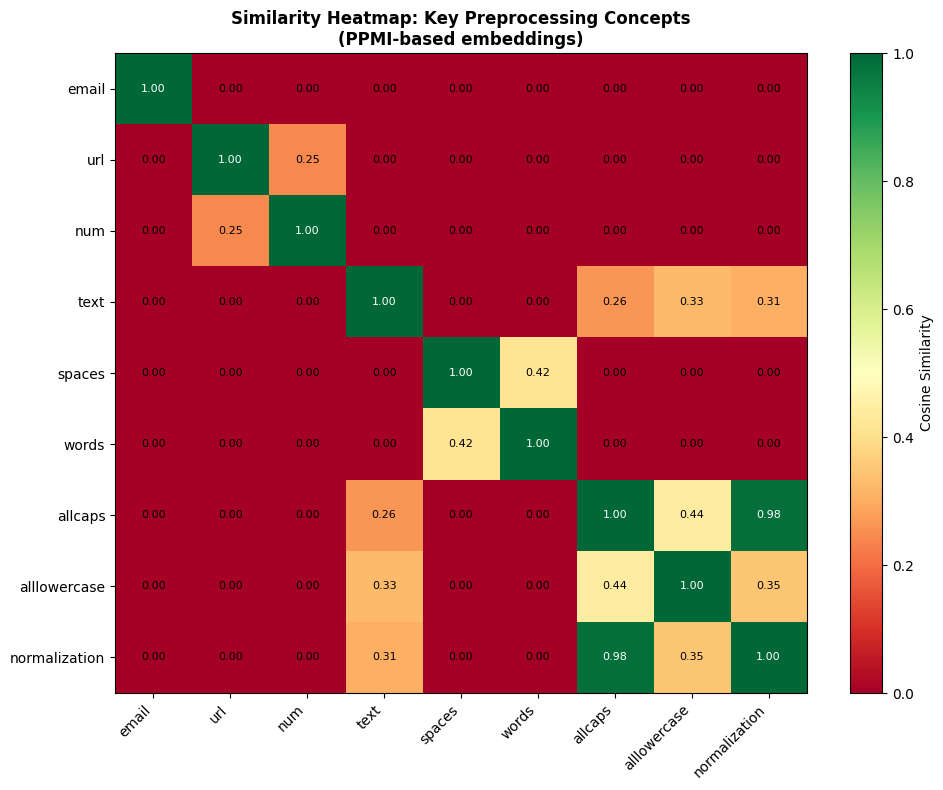


✅ Visualization complete! Check the saved PNG files.


In [33]:
# ============================================================
# SIMILARITY HEATMAP FOR KEY CONCEPTS
# ============================================================

print("\n" + "="*60)
print("SIMILARITY HEATMAP - Key Preprocessing Concepts")
print("="*60)

# Select key preprocessing words
key_concepts = ['email', 'url', 'num', 'text', 'spaces', 'words',
                'allcaps', 'alllowercase', 'normalization']
key_concepts = [w for w in key_concepts if w in word2idx]

# Build similarity matrix
n = len(key_concepts)
sim_matrix = np.zeros((n, n))

for i, word1 in enumerate(key_concepts):
    for j, word2 in enumerate(key_concepts):
        if i != j:
            sim_matrix[i, j] = get_word_similarity(pmi_matrix, word2idx, word1, word2)
        else:
            sim_matrix[i, j] = 1.0

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(n), key_concepts, rotation=45, ha='right')
plt.yticks(range(n), key_concepts)
plt.title('Similarity Heatmap: Key Preprocessing Concepts\n(PPMI-based embeddings)',
          fontsize=12, fontweight='bold')

# Add values to cells
for i in range(n):
    for j in range(n):
        plt.text(j, i, f'{sim_matrix[i, j]:.2f}',
                ha='center', va='center',
                color='white' if sim_matrix[i, j] > 0.5 else 'black',
                fontsize=8)

plt.tight_layout()
plt.savefig('preprocessing_similarity_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: preprocessing_similarity_heatmap.png")
plt.show()

print("\n✅ Visualization complete! Check the saved PNG files.")